<a href="https://colab.research.google.com/github/CarlosSMWolff/Photon-Bundles/blob/main/1-Steady-state-and-spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emission of $N$-photon bundles in superconducting systems.

Related papers:

In this notebook we present several calculations discussing the possibility of observing photon-bundle emission in superconducting architectures consisting of one cavity and one strongly-driven qubit.

[Emitters of N-photon bundles (Nature Photonics)](https://www.nature.com/articles/nphoton.2014.114)


[Filtering multiphoton emission from state-of-the-art cavity quantum electrodynamics (Optica)](https://opg.optica.org/optica/fulltext.cfm?uri=optica-5-1-14&id=380596)

![Paper](https://carlossanchezmunoz.weebly.com/uploads/1/3/2/3/132365119/transitions_2.png)

# Required code to set up the notebook

## Import necessary packages

In [1]:
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  ! pip install qutip

import numpy as np
from qutip import *

from numpy import sqrt, pi
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import spsolve
if qutip.settings.has_mkl:
    from qutip._mkl.spsolve import mkl_spsolve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Definitions of Hamiltonian, Liouvillian and useful functions 

We will define a cavity with annihilation operator $\hat a$, and a qubit given by a cavity with annihilation operator $\hat b$ and a Kerr-type nonlinearity $U$.

In [2]:
Ncav = 3     # Truncation number in the cavity 
Nqubit = 2    # Trunction number in the qubit-cavity

a = tensor(destroy(Ncav), qeye(Nqubit))
b = tensor(qeye(Ncav), destroy(Nqubit))

vac = tensor(basis(Ncav,0), basis(Nqubit,0))

We define a function to create the following Hamiltonian, in the rotating frame of a coherent drive:

$ \hat H = \Delta_a \hat a^\dagger \hat a + \Delta_q \hat b ^\dagger \hat b 
+ U \hat b^\dagger \hat b^\dagger \hat b \hat b + g(\hat a^\dagger \hat b + \hat a \hat b^\dagger )  + \Omega_a (\hat a + \hat a^\dagger) + \Omega_q(\hat b + \hat b^\dagger)$

We assume:


1.  Qubit described by Kerr cavity
2.   Jaynes-Cummings interaction




In [168]:
def gen_Hamiltonian(params:list):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  H = (Delta_a * a.dag()*a + Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b +
       g*(a.dag()*b + b.dag()*a) 
  + Omega_a*(a.dag()+a) + Omega_q*(b.dag()+b))
  return H

def gen_Liouv(params: list):
  H = gen_Hamiltonian(params)
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return liouvillian(H, c_ops)

def compute_spectrum_qutip(params: list, omega_grid, op):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params

  H = gen_Hamiltonian(params)
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return spectrum(H, omega_grid, c_ops, op.dag(), op)


def SpectrumNoEig(omega, liouv, a, Gamma, rhs = None):
  liouvM=liouv.data
  h2 = liouvM.shape[0] # Hilbert size ^2
  id = sp.identity(h2)

  if rhs ==None:
    rho_ss = steadystate(liouv)
    rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]
  rho_eff = spsolve(liouvM + 1j*id*omega -Gamma/2*id, rhs).reshape((h,h))

  np.real((-aM@rho_eff).trace()/pi)
  #return -np.real(np.trace(aM*rho_eff))/pi
  return np.real((-aM@rho_eff).trace()/pi)

def Spectrum(omega_list, liouv, Gamma, a):
  # Gamma is the filter linewidth
  liouvM=liouv.data
  h2 = liouv.shape[0] # Hilbert size ^2
  id = sp.identity(h2)
  rho_ss = steadystate(liouv)
  rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]

  eigen_vecs=liouv.eigenstates()
  E = np.transpose(np.reshape(
      np.array([eigen_vecs[1][i].full() for i in range(h2)]), 
      (h2,h2)))
  Einv = np.linalg.inv(E)
  EinvTr = Einv.T
  eigvals = eigen_vecs[0]
  Einvrhs=EinvTr@rhs

  Elist = E, Einvrhs, rhs, eigvals 


  spectrumgrid = np.asarray(
      [-np.real(
      (aM@(
          ((
          E@np.transpose(
              1/(eigvals - 1j*omega - Gamma/2)*EinvTr)          
          )@rhs).reshape((h,h))
          )).trace()
      )/pi for omega in omega_list] 
  )
  return spectrumgrid

# Definition of system parameters

These are the parameters that I will leave fixed for the rest of the notebook. Notice that, in the bundling regime, the following relations must hold:

$$ g \ll \Delta_a=\Omega_q \ll U  $$

Explanation:



1.   $g \ll \Delta_a$ is required so that first-order qubit-atom coupling effects are well out of resonance. This way we are sure that **only photon pairs are exchanged** between cavity and dressed qubit at the two-photon resonance $\Omega_q=\Delta_a$.
2.   $ \Omega_q \ll U  $ is required to keep the two-level system approximation. This condition could be relaxed, but the results become more complicated to interpret. 



In [4]:
# System parameters in MHz

U = -100 
g = 1 

kappa = 0.5
gamma_phi = 0.5
gamma_q = 0.05

Delta_a = 10*g
Delta_q = 0

# Scheme #1 (More desirable)

*   **Driving**: Qubit
*   **Output measured**: Cavity

Experiment: The Rabi frequency of the qubit driving $\Omega_q$ is increased and the spectrum of emission from the cavity is measured. A resonant feature should be observed when the cavity frequency is exactly between the central Mollow peak and one of the Mollow sidebands, i.e., when $\Omega_q =\Delta_a$

**Why desirable?**
Here, the signal is not covered by the coherent drive. The driving and the detection occur in different channels, and the cavity does not build up a strong coherent population, but only the fully quantum signal made up of photon pairs.

![Scheme](https://drive.google.com/uc?id=1lnL7JpQ93IjR8YmQKFQoyTWfR-GpYGWd)

In [116]:
# Define range of Rabi frequencies
Omega_q_min, Omega_q_max, nOmega = 0.1, 15*g, 100
Omega_q_grid = np.linspace(Omega_q_min, Omega_q_max, nOmega)
Omega_a = 0

# Grid of frequencies for the spectrum measurement 
omega_min = -2*Omega_q_max; omega_max = -omega_min; nomega = 200
omega_grid = np.linspace(omega_min, omega_max, nomega)

Gamma = 0.05

params_list = [[Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi] for Omega_q in Omega_q_grid]

In [117]:
# Cut of the spectra at cavity frequency 

spectrum_array = np.asarray(
    [Spectrum(omega_grid, gen_Liouv(params), Gamma, a) for params in tqdm(params_list)]
)

idx_cav = np.argmin(np.abs(omega_grid - Delta_a))
spectrum_at_cavity = spectrum_array[:,idx_cav]

100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


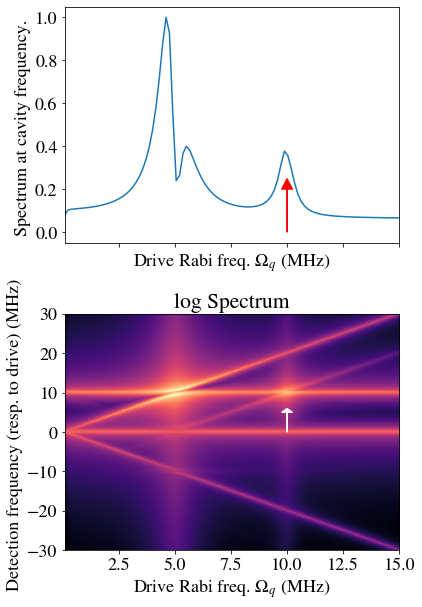

In [118]:
fig, (ax1, ax2) = plt.subplots(figsize = (6,10),nrows = 2, sharex=True)

ax = ax1
ax.plot(Omega_q_grid, spectrum_at_cavity/np.max(spectrum_at_cavity))
ax.set_ylabel('Spectrum at cavity frequency. ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')

ax.arrow(Delta_a, 0, 0, 0.2, width=0.01, head_width=0.5, head_length=0.05, color='red')

ax = ax2
ax.imshow(np.flip((np.log10(np.abs(np.flip(spectrum_array.T,axis=1))))), extent = [Omega_q_min, Omega_q_max,omega_min, omega_max], cmap = 'magma')
ax.arrow(Delta_a, 0, 0, 5, width=0.01, head_width=0.5, head_length=1, color='w')
ax.set_aspect('auto')
plt.subplots_adjust(hspace=0.3)

ax.set_ylabel('Detection frequency (resp. to drive) (MHz) ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')
ax.set_title('log Spectrum')


plt.show()

The peak observed in the emission at the cavity frequency is an **unequivocal signature of the two-photon emission**. 

In this architecture, resolving the spectrum of the emission is not strictly necessary: photon counting on the full emission from the cavity should also reveal **strong features in the cavity population and the second-order correlation function**, given that the two-photon mechanism mainly responsible for the cavity population:

In [119]:
G2array = np.asarray(
    np.asarray([expect(a.dag()*a.dag()*a*a,steady(gen_Liouv(params))) for params in params_list])
)
naarray = np.asarray(
    np.asarray([expect(a.dag()*a,steady(gen_Liouv(params))) for params in params_list])
)
g2array =G2array/naarray**2

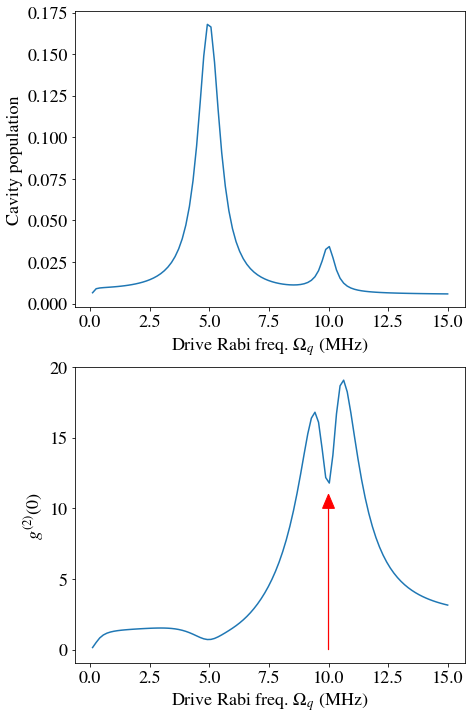

In [120]:
fig, axis = plt.subplots(nrows=2, figsize=(7,12))

ax = axis[0]
ax.plot(Omega_q_grid,naarray)
ax.set_ylabel('Cavity population')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')


ax = axis[1]
ax.plot(Omega_q_grid,g2array)
ax.set_ylabel('$g^{(2)} (0)$')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')

ax.arrow(Delta_a, 0, 0, 10, width=0.01, head_width=0.5, head_length=1, color='red')
plt.show()

# Scheme # 2 

*   **Driving**: Cavity
*   **Output measured**: Cavity

Experiment: Now the cavity is driven with an input field 

$$ a_\text{IN}/\sqrt{\kappa} = \frac{\alpha}{\sqrt{2\pi}} e^{i\omega_L t} $$

In the frame rotating at $\omega_L$ leads to a coherent driving term for the cavity

$$\Omega_a (a + a^\dagger) $$

with

$$\Omega_a =  i\sqrt\frac{1}{2\pi}\kappa \alpha.$$

This driving is resonant with the qubit, not with the cavity, which is detuned by $\Delta_a$. The coherent amplitude built in the cavity by the drive is

$$ \alpha_c = \frac{\Omega_a}{\kappa/2 + i \Delta_a} =  i\sqrt\frac{1}{2\pi}\frac{\alpha}{1/2 + i \Delta_a/\kappa} $$

which induces a drive in the qubit with a value $\Omega_q = g \alpha_c$.

We can perform the same experiment we did as before and spectrally resolve the emission: the coherent fraction will give a $\delta$-like contribution at the driving frequency, while the main features we are looking for appear at the cavity frequency, which is separated from the drive frequency by $\Delta_a$. In order to resolve this, we need the emission at the cavity frequency to be larger than the coherent fraction capture by the finite-linewidth sensor. 

![Scheme](https://drive.google.com/uc?id=1s6zPi-NiDuIk2_QRBQx7YJrWg7fEChDI)


Using input-output theory, we have that our output operator will be given by

$$ a_\text{OUT} = a_\text{IN} + \sqrt{\kappa} a, $$

and writting $ a \rightarrow \alpha_c + a$, we find


$$ a_\text{OUT}/ \sqrt \kappa = \beta + a, $$

with $$ \beta \equiv \frac{\alpha}{\sqrt{2\pi}}\left(1+\frac{i}{1/2 + i \Delta_a/\kappa} \right) $$

and $\langle a \rangle = 0$. The spectrum of  $a_\text{OUT}/ \sqrt \kappa $ will have a coherent contribution from the $\beta$ term, and and incoherent contribution from $a$

$$S(\omega) = S_C(\omega) + S_I(\omega)$$

with 

$$  S_C(\omega) = \frac{1}{\pi} \frac{\Gamma/2}{\frac{\Gamma^2}{4}+\omega^2}|\beta|^2 $$

and $S_I(\omega) = \frac{1}{\pi}\Re \int_0^\infty e^{i\omega\tau-\Gamma/2\tau}\langle a^\dagger(0)a(\tau)\rangle d\tau$.

By fixing the desired $\Omega_q$, we see that the required value of $\alpha$ is 

$$\alpha = -i\frac{\Omega_q}{g} \sqrt{2\pi} (1/2 + i\Delta_a/\kappa) $$ and therefore 

 $$ \beta \equiv  \frac{\Omega_q}{g} \left(1+\Delta_a/\kappa-i/2\right) $$


In [128]:
def Spectrum_C(omega_list, Gamma, params):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi = params
  beta = Omega_q/g*(1+Delta_a/kappa - 1j/2)
  return np.abs(beta)**2 * Gamma/2 * (1/(omega_list)**2 + Gamma**2/4) /pi

In [129]:
# Define range of Rabi frequencies
Omega_q_min, Omega_q_max, nOmega = 0.1, 15*g, 100
Omega_q_grid = np.linspace(Omega_q_min, Omega_q_max, nOmega)
Omega_a = 0

# Grid of frequencies for the spectrum measurement 
omega_min = -2*Omega_q_max; omega_max = -omega_min; nomega = 200
omega_grid = np.linspace(omega_min, omega_max, nomega)

Gamma = 0.05

params_list = [[Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi] for Omega_q in Omega_q_grid]

We compute the spectrum as before, remember this is the incoherent fraction $S_I$ with contains the relevant information

In [ ]:
# Compute incoherent spectrum
spectrum_I_array = np.asarray(
    [Spectrum(omega_grid, gen_Liouv(params), Gamma, a) for params in tqdm(params_list)]
)

In [133]:
# Compute coherent spectrum
spectrum_C_array = np.asarray(
    [Spectrum_C(omega_grid, Gamma, params) for params in params_list]
)

In [136]:
# Cut of the spectra at cavity frequency 

idx_cav = np.argmin(np.abs(omega_grid - Delta_a))
spectrum_at_cavityI = spectrum_I_array[:,idx_cav]
spectrum_at_cavityC = spectrum_C_array[:,idx_cav]
spectrum_at_cavity = spectrum_at_cavityC+spectrum_at_cavityI
spectrum_array = spectrum_C_array+ spectrum_I_array

With this parameters, we see the problematic: our coherent fraction covers the features of interest

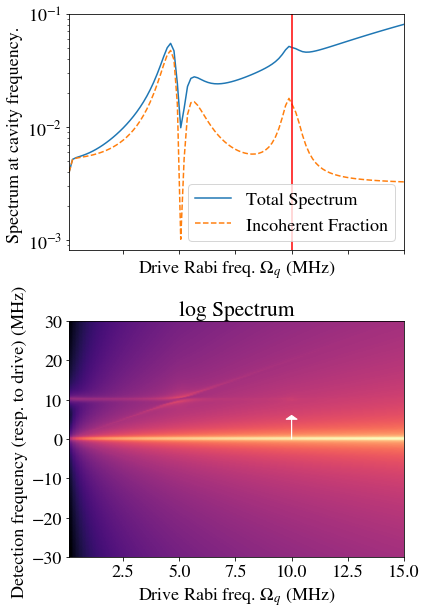

In [147]:
fig, (ax1, ax2) = plt.subplots(figsize = (6,10),nrows = 2, sharex=True)

ax = ax1
ax.plot(Omega_q_grid, spectrum_at_cavity, label='Total Spectrum')
ax.plot(Omega_q_grid, spectrum_at_cavityI,'--',  label='Incoherent Fraction')
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Spectrum at cavity frequency. ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')

ax.axvline(Delta_a,color='red')

ax = ax2
ax.imshow(np.flip((np.log10(np.abs(np.flip(spectrum_array.T,axis=1))))), extent = [Omega_q_min, Omega_q_max,omega_min, omega_max], cmap = 'magma')
ax.arrow(Delta_a, 0, 0, 5, width=0.01, head_width=0.5, head_length=1, color='w')
ax.set_aspect('auto')
plt.subplots_adjust(hspace=0.3)

ax.set_ylabel('Detection frequency (resp. to drive) (MHz) ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')
ax.set_title('log Spectrum')


plt.show()

We can try to solve this by using a much narrower detection linewidth

In [149]:
Gamma = 0.00005

In [150]:
spectrum_I_array = np.asarray(
    [Spectrum(omega_grid, gen_Liouv(params), Gamma, a) for params in tqdm(params_list)]
)

spectrum_C_array = np.asarray(
    [Spectrum_C(omega_grid, Gamma, params) for params in params_list]
)

idx_cav = np.argmin(np.abs(omega_grid - Delta_a))
spectrum_at_cavityI = spectrum_I_array[:,idx_cav]
spectrum_at_cavityC = spectrum_C_array[:,idx_cav]
spectrum_at_cavity = spectrum_at_cavityC+spectrum_at_cavityI
spectrum_array = spectrum_C_array+ spectrum_I_array

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


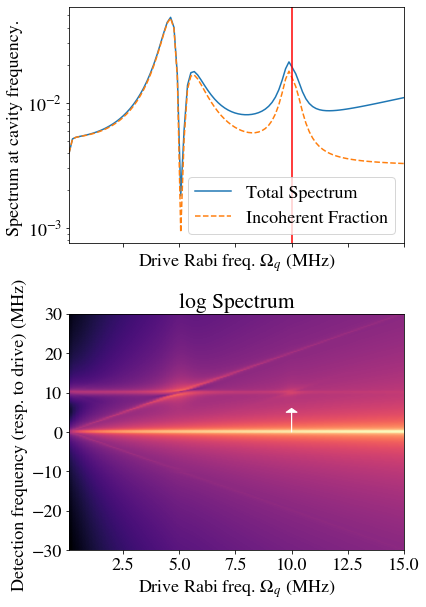

In [151]:
fig, (ax1, ax2) = plt.subplots(figsize = (6,10),nrows = 2, sharex=True)

ax = ax1
ax.plot(Omega_q_grid, spectrum_at_cavity, label='Total Spectrum')
ax.plot(Omega_q_grid, spectrum_at_cavityI,'--',  label='Incoherent Fraction')
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Spectrum at cavity frequency. ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')
ax.axvline(Delta_a,color='red')


ax = ax2
ax.imshow(np.flip((np.log10(np.abs(np.flip(spectrum_array.T,axis=1))))), extent = [Omega_q_min, Omega_q_max,omega_min, omega_max], cmap = 'magma')
ax.arrow(Delta_a, 0, 0, 5, width=0.01, head_width=0.5, head_length=1, color='w')
ax.set_aspect('auto')
plt.subplots_adjust(hspace=0.3)

ax.set_ylabel('Detection frequency (resp. to drive) (MHz) ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')
ax.set_title('log Spectrum')


plt.show()

# Effects beyond TLS approximation (nonlinear oscillator)

Our approach will consist on dressing the qubit states with the laser, enabling non-number conserving interactions with the cavity. Here, we will see that if $\Omega_q > U$, we will be seeing higher levels in the qubit. If we want to keep a simple description based on a qubit, $U$ will set a limit to the power with which we drive the qubit. We can still see interesting things for higher powers, but we loose the qubit description and the physics becomes messier.

In [ ]:
Nqubit = 7
b = destroy(Nqubit)

def gen_H_qubit(params_H:list):
  # This function generates a Hamiltonian in the rotating frame of the drive.
  # Both qubit and cavity can be directly driven in this scheme 

  Delta_q, U, Omega_q = params_H
  H = (Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b + Omega_q*(b.dag()+b))
  return H

In [ ]:
Omega_q_min = 0.; Omega_q_max = 200; nOmega = 100;
Omega_q_list = np.linspace(Omega_q_min, Omega_q_max, nOmega)

U = -100

In [ ]:
eigen_Omega = np.asarray([gen_H_qubit([0., U, Omega_q]).eigenenergies() for Omega_q in Omega_q_list])
eigen_Omega.shape

(100, 7)

Here we see that for $\Omega_q \ll U$ (with U the red line), the states $|0\rangle$ and $|1\rangle$ are dressed, while the higher states stay pretty much the same.

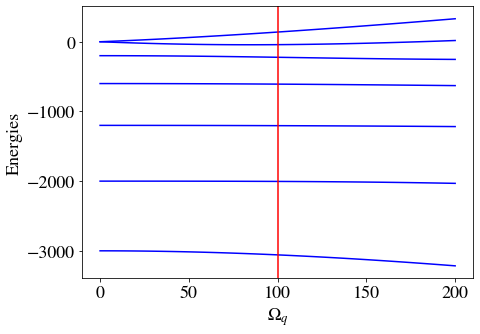

In [ ]:
fig, ax = plt.subplots(figsize= (7,5))
for idx in range(Nqubit):
  ax.plot(Omega_q_list, eigen_Omega[:,idx], 'b-')
ax.set_xlabel("$\Omega_q$"); ax.set_ylabel("Energies")
ax.axvline(x=np.abs(U), color='red')
plt.show()

In [ ]:
Omega_q = 10
vac_q = basis(Nqubit,0)

tini = 0.; tfin = 4*2*pi/Omega_q; nt = 1000; times = np.linspace(tini, tfin, nt)
H = gen_H_qubit([0., U, Omega_q])
                
result = mesolve(H, rho0 = vac_q,  tlist = times, c_ops = [])

In [ ]:
def pop_time_index(idx, result):
  return [np.squeeze(np.abs(psi[idx])**2) for psi in result.states]

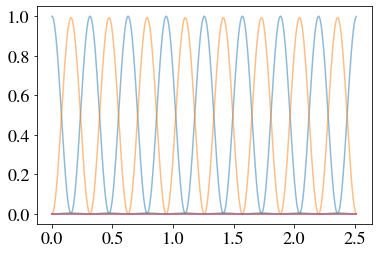

In [ ]:
for idx in range(Nqubit):
  plt.plot(times, pop_time_index(idx,result), alpha = 0.5)

plt.show()